In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import sys
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})

In [2]:
nTurn = 1024*4
npt = 310

nCore_y = 2
nCore_z = 2

NL_c = 0.01
NL_t = 0.4
NL_nu= 0.3
NL_L = 1.8
dTune = 0.0

alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)

# 1. Preparation

In [3]:
beam, lattice = impact.readInputFile('test_toymodel.in');
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.distribution_type = 'ReadFile'
beam.current = 0.0

ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

reading ImpactZ input file (test_toymodel.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [5]:
for i in range(len(lattice)-1,0,-1):
    if lattice[i].type == 'write_raw_ptcl':
        lattice.pop(i)
lattice[1].n_sckick = 100
lattice[1].length = NL_L
lattice[1].strength_t = NL_t
lattice[1].transverse_scale_c = NL_c
lattice[1].tune_advance = NL_nu

lattice[2].tune_advance = dTune
lattice[2].nonlinear_insert_tuneAdvance = NL_nu
lattice[2].nonlinear_insert_length = NL_L

In [6]:
lattice[0].turns = nTurn

TBT = impact.getElem('TBT')
TBT.file_id = 5555
TBT.pID_begin = 1
TBT.pID_end = npt
lattice.insert(1,TBT)

# prepare particles

In [7]:
data=np.loadtxt('critical_points.data')
print(data.shape)

(310, 2)


In [8]:
k=0
q_m = beam.multi_charge.q_m[0]
pTest = np.zeros([npt,9])
pTest[:,6] = q_m
pTest[:,-1] = np.arange(1,npt+1)
pTest[:,0] = data[:,0]
pTest[:,2] = data[:,1]
beam.n_particles = npt
unnormalize(pTest)

In [9]:
impact.writeParticleData(pTest, ke, mass, freq)
impact.writeInputFile(beam,lattice) 
impact.run(beam)

0

In [10]:
iTBT,TBT = impact.readTBT(5555,ke,mass,freq)
print(len(iTBT))
print(TBT.shape)

310
(4096, 6, 310)


In [11]:
X = np.zeros([nTurn,npt],dtype=np.complex64)
Y = np.zeros([nTurn,npt],dtype=np.complex64)
for i in range(nTurn):
    X[i,:] = (TBT[i,0,:] - 1j*(betx*TBT[i,1,:]+alfx*TBT[i,0,:]))/(NL_c*np.sqrt(betx))
    Y[i,:] = (TBT[i,2,:] - 1j*(betx*TBT[i,3,:]+alfx*TBT[i,2,:]))/(NL_c*np.sqrt(betx))

In [12]:
tuneX = np.zeros(npt)
tuneY = np.zeros(npt)
for i in range(npt):
    signal = X[:,i] - X[:,i].mean()
    tuneX[i], amp, dummy = impact.util.naff(1,signal)
    signal = Y[:,i] - Y[:,i].mean()
    tuneY[i], amp, dummy = impact.util.naff(1,signal)

# Plot

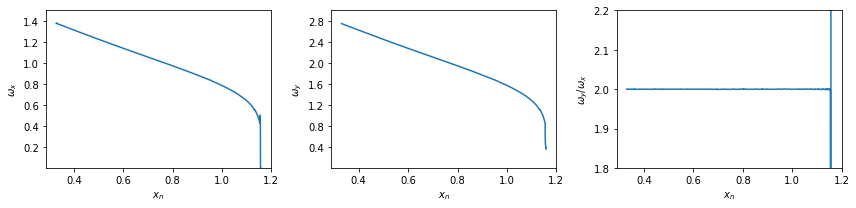

In [32]:
ticks = np.array([.2,.4,.6,.8,1.,1.2,1.4])
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(np.real(X[0,:]),tuneX/0.3)
plt.xlabel('$x_n$');
plt.ylabel(r'$\omega_x$');
plt.ylim((0,1.5))
plt.yticks(ticks)
plt.subplot(1,3,2)
checkindex = np.argwhere(np.real(X[0,:])>0.33)
plt.plot(np.real(X[0,checkindex]),tuneY[checkindex]/0.3)
plt.xlabel('$x_n$');
plt.ylabel(r'$\omega_y$');
plt.yticks(2*ticks)
plt.ylim(0,3.0)
plt.subplot(1,3,3)
plt.plot(np.real(X[0,checkindex]),tuneY[checkindex]/tuneX[checkindex])
plt.xlabel('$x_n$');
plt.ylabel(r'$\omega_y/\omega_x$');
plt.ylim(1.8,2.2)
plt.tight_layout()
plt.savefig('tune.onCritical.png',dpi=180)

In [16]:
i=np.argmin(np.real(X[0,:]))

In [17]:
np.real(X[0,i])

0.32685742

In [19]:
tuneX[i]/0.3

1.3768578454512188